$\textbf{Empirical Exercises for Week I}$

$\textit{GARCH Estimation for Asset Returns}$

In the following code, read into the workspace the spreadsheet giving data from 16 Chinese banks, the offshore and on shore rates and the indices of Global Economic Uncertainty.
You will need the m file rangefun.m in your workspace since this program converts daily data for open, high, low and closing share prices to estiamtes of daily Range Volatility.  

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import arch
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt

In [2]:
TAB =pd.read_excel('China_All_Data.xls')

In [3]:
date1=TAB.loc[2:,1].reset_index(drop=True)
Controls = TAB.loc[2:,2:17].reset_index(drop=True).ffill()
SpotSpread = TAB.loc[2:,35:36].reset_index(drop=True).ffill()
SharePrice = TAB.loc[2:,37:].reset_index(drop=True).ffill()
(rshare, cshare) = SharePrice.shape

In [4]:
SharePrice = SharePrice.iloc[1:,:].reset_index(drop=True)
index1 = np.arange(0,cshare,4)
OpenPrice = SharePrice.iloc[:,index1]
index2 = np.arange(1,cshare,4)
HighPrice = SharePrice.iloc[:,index2]
index3 = np.arange(2,cshare,4)
LowPrice = SharePrice.iloc[:,index3]
index4 = np.arange(3,cshare,4)
ClosePrice = SharePrice.iloc[:,index4]

In [5]:
def rangefun(Data):
    data = np.log(Data);
    open = data.iloc[:,0];
    high =  data.iloc[:,1];
    low = data.iloc[:,2];
    close = data.iloc[:,3];
    rangevol =  .511*(high-low)**2-.019*((close-open)* (high+low-2*open)-2*(high-open)*(low-open))-.383*(close-open)**2
    return rangevol

In [6]:
(rRange, cRange) = ClosePrice.shape
RangeVol=np.zeros((rRange,cRange))
for i in range(cRange):
    Data=  pd.DataFrame([OpenPrice.iloc[:,i],HighPrice.iloc[:,i],LowPrice.iloc[:,i],ClosePrice.iloc[:,i]]).transpose()
    RangeVol[:,i] = rangefun(Data)

In [7]:
Return = np.log(ClosePrice).diff().iloc[1:]
(rRange, cRange) = RangeVol.shape
numseries = cRange
numlags = 3

In [8]:
RangeVol1 = (RangeVol-RangeVol.min(0))/(RangeVol.max(axis=0)-RangeVol.min(0))
Controls1 = (Controls-Controls.min(0))/(Controls.max(axis=0)-Controls.min(0))

The Rangevol matrix is the matrix of the dependenet variables, the Controls are the indices of global uncertainty, and the returns are the log first-differenced daily closeing share prices.

Let's estimate a GARCH(1,1) for the last return in the spreadsheet, it is that of the offshore Hong Kong spot rate.

In [9]:
Mdl1=arch.arch_model(1000*Return.iloc[:,-1],vol='GARCH', p=1,q=1).fit()
v=Mdl1.forecast(start = 0, method='simulation').variance/1e6

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4614.525056648815
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4611.355780105414
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4609.716907087901
Iteration:      4,   Func. Count:     35,   Neg. LLF: 4608.027353515724
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4604.696889493811
Iteration:      6,   Func. Count:     51,   Neg. LLF: 4603.205056157738
Iteration:      7,   Func. Count:     57,   Neg. LLF: 4602.829518878987
Iteration:      8,   Func. Count:     63,   Neg. LLF: 4602.76290414283
Iteration:      9,   Func. Count:     69,   Neg. LLF: 4602.72369434832
Iteration:     10,   Func. Count:     75,   Neg. LLF: 4602.718743120689
Iteration:     11,   Func. Count:     81,   Neg. LLF: 4602.718547675349
Iteration:     12,   Func. Count:     87,   Neg. LLF: 4602.718522616383
Iteration:     13,   Func. Count:     93,   Neg. LLF: 4602.718521007555
Optimization terminated successfully.    (Exit mode 0)
           

In [10]:
Mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    104   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4602.72
Distribution:                  Normal   AIC:                           9213.44
Method:            Maximum Likelihood   BIC:                           9236.17
                                        No. Observations:                 2170
Date:                Mon, Oct 26 2020   Df Residuals:                     2166
Time:                        16:41:06   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0402  4.468e-02     -0.901      0.368 [ -0.128,4.733e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2085      0.166      1.257      0.209   [ -0.117,  0.534]
alpha[1]       0.0724  1.715e-02      4.220  2.439e-05 [3.877e-02,  0.106]
beta[1]        0.8866  2.893e-02     30.652 2.487e-206   [  0.830,  0.943]
==========================================================================

Covariance estimator: robust
"""

We have estimated a GARCH process for the off-shore daily change in the exchange rate. The estimate shows that there is a lot of inertia in the volatility, with a persistence parameter of .89.

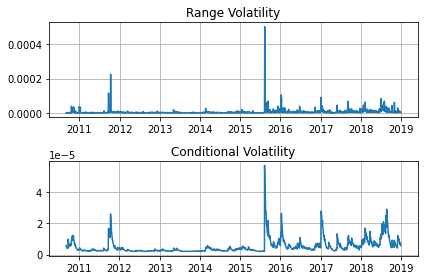

In [11]:
fig,(ax1,ax2)=plt.subplots(2,1)
ax1.plot(date1.iloc[1:],RangeVol[:,-1])
ax1.set_title('Range Volatility')
ax1.grid()
ax2.plot(date1.iloc[2:],v)
ax2.set_title('Conditional Volatility')
ax2.grid()
plt.tight_layout()

We plot above the calulated Range Volatlity from daily opening-high-low-cloasing data with the conditioal volatlity obtained by the GARCH estimation. Note the differences.

Repeat this for other variables, see how well the Range volatlity and the conditional GARCH volatility measures follow each other.

Now let's estimate an EGARCH model. We discussed this EGARCH model in Week 9 of Financial Econometrics.

In [12]:
Mdl2=arch.arch_model(1000*Return.iloc[:,-1],vol='EGARCH', p=1,o=1,q=1).fit()
v2=Mdl2.forecast(start = 0, method='simulation').variance/1e6

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4661.0488514693625
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4654.399616647377
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4653.059901449926
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4652.376153169049
Iteration:      5,   Func. Count:     52,   Neg. LLF: 4652.0857600004165
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4650.065802174496
Iteration:      7,   Func. Count:     68,   Neg. LLF: 4648.566638101106
Iteration:      8,   Func. Count:     76,   Neg. LLF: 4647.071861269456
Iteration:      9,   Func. Count:     84,   Neg. LLF: 4646.044029365471
Iteration:     10,   Func. Count:     92,   Neg. LLF: 4644.2523571073525
Iteration:     11,   Func. Count:    100,   Neg. LLF: 4644.216459954769
Iteration:     12,   Func. Count:    108,   Neg. LLF: 4644.208565308798
Iteration:     13,   Func. Count:    116,   Neg. LLF: 4644.207543320437
Iteration:     14,   Func. Count:    124,   Neg. LLF: 4644.20

In [13]:
Mdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                    104   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4644.21
Distribution:                  Normal   AIC:                           9298.41
Method:            Maximum Likelihood   BIC:                           9326.83
                                        No. Observations:                 2170
Date:                Mon, Oct 26 2020   Df Residuals:                     2165
Time:                        16:41:20   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0160  4.993e-03      3.201  1.367e-03 [6.199e-03,2.577e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0760  5.492e-02      1.385      0.166  [-3.159e-02,  0.184]
alpha[1]       0.0957  5.616e-02      1.704  8.835e-02  [-1.437e-02,  0.206]
gamma[1]       0.0345  1.728e-02      1.997  4.583e-02 [6.391e-04,6.838e-02]
beta[1]        0.9575  3.108e-02     30.808 2.050e-208     [  0.897,  1.018]
============================================================================

Covariance estimator: robust
"""

We see even higher persistence effect in the EGARCH model as well as a significant "leverage" effect. The leverage effect captures the face that negative surprise returns have stronger effects on volatility than positive surprise returns.

Let's plot the two conditional volatility measures together to see how they contrast with the Range volatility measure.

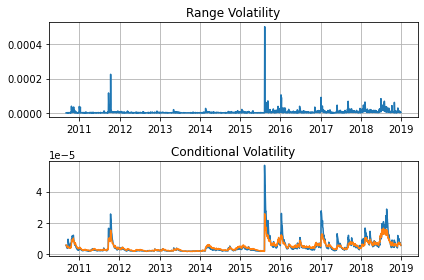

In [14]:
fig,(ax1,ax2)=plt.subplots(2,1)
ax1.plot(date1.iloc[1:],RangeVol[:,-1])
ax1.set_title('Range Volatility')
ax1.grid()
ax2.plot(date1.iloc[2:],v)
ax2.plot(date1.iloc[2:],v2)
ax2.set_title('Conditional Volatility')
ax2.grid()
plt.tight_layout()

Compare the differences of the GARCH and EGARCH conditional volatilities for other assets.

$\textit{VARX Estimation for Share Price Volatilities}$

Now we will estimate a VAR model for the system, 16 banks and the off-shore HK exchange market as the "state variables" with the Economic Policy Uncertainty indices as the "controls". As you see below, we first "normalize" the RangevVol and Controls between zero and one. Then we adjust them to the number of lags for y and x. We specify the model as a VARM (Var model) for the number of series and lags. The estimate function gives the estimated model parameters for y and x. The value h gives the Granger causality test for each of the state variables on each other. Decomp gives the forcast error variance decomposition for state variables. Basically for horizon 12, we show how much of the total error variance is explained by the shocks to each of the state variables. It is an out-of-sample Granger causality test.

In [15]:
y = RangeVol1[numlags:]  #state variables
x = Controls1[numlags+1:]  #controls

In [16]:
Mdl = VAR(y,x)
EstMdl = Mdl.fit(3)

In [17]:
EstMdl.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Oct, 2020
Time:                     16:41:51
--------------------------------------------------------------------
No. of Equations:         17.0000    BIC:                   -118.867
Nobs:                     2165.00    HQIC:                  -120.791
Log likelihood:           80889.0    FPE:                1.14697e-53
AIC:                     -121.900    Det(Omega_mle):     6.77995e-54
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.122748         0.017857            6.874           0.000
exog0          0.076834         0.045966            1.672           0.095
exog1         -0.029531         0.016277           -1.814           0.070
exog2         -0.

In [19]:
#Granger-Causality Test
pvals=[]
hs=[]
for i in range(cRange):
    for j in range(cRange):
        gcresult=grangercausalitytests(y[:,[i,j]], maxlag=3)
        pvals.append(gcresult[3][0]['params_ftest'][1])
        hs.append(gcresult[3][0]['params_ftest'][1]<=0.05)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2165, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=492.3392, p=0.0000  , df_denom=2165, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2163, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=353.4152, p=0.0000  , df_denom=2163, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2161, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=247.9642, p=0.0000  , df_denom=2161, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=68.8839 , p=0.

likelihood ratio test: chi2=42.0893 , p=0.0000  , df=3
parameter F test:         F=14.1212 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=87.8484 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=87.9702 , p=0.0000  , df=1
likelihood ratio test: chi2=86.2315 , p=0.0000  , df=1
parameter F test:         F=87.8484 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=34.5208 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=69.2014 , p=0.0000  , df=2
likelihood ratio test: chi2=68.1189 , p=0.0000  , df=2
parameter F test:         F=34.5208 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=26.3312 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=79.2498 , p=0.0000  , df=3
likelihood ratio test: chi2=77.8338 , p=0.0000  , df=3
parameter F test:         F=26.33

likelihood ratio test: chi2=31.6968 , p=0.0000  , df=1
parameter F test:         F=31.8856 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.3586  , p=0.0002  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=16.7560 , p=0.0002  , df=2
likelihood ratio test: chi2=16.6915 , p=0.0002  , df=2
parameter F test:         F=8.3586  , p=0.0002  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2426  , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=27.8179 , p=0.0000  , df=3
likelihood ratio test: chi2=27.6407 , p=0.0000  , df=3
parameter F test:         F=9.2426  , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8295  , p=0.0927  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=2.8334  , p=0.0923  , df=1
likelihood ratio test: chi2=2.8316  , p=0.0924  , df=1
parameter F test:         F=2.829

likelihood ratio test: chi2=7.8501  , p=0.0492  , df=3
parameter F test:         F=2.6130  , p=0.0497  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4684 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=49.5369 , p=0.0000  , df=1
likelihood ratio test: chi2=48.9792 , p=0.0000  , df=1
parameter F test:         F=49.4684 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.3443 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=36.7735 , p=0.0000  , df=2
likelihood ratio test: chi2=36.4648 , p=0.0000  , df=2
parameter F test:         F=18.3443 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.5263 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=40.7104 , p=0.0000  , df=3
likelihood ratio test: chi2=40.3324 , p=0.0000  , df=3
parameter F test:         F=13.52

parameter F test:         F=24.0626 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6379  , p=0.0013  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=13.3065 , p=0.0013  , df=2
likelihood ratio test: chi2=13.2658 , p=0.0013  , df=2
parameter F test:         F=6.6379  , p=0.0013  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3302  , p=0.0047  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=13.0327 , p=0.0046  , df=3
likelihood ratio test: chi2=12.9937 , p=0.0047  , df=3
parameter F test:         F=4.3302  , p=0.0047  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=68.1416 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=68.2360 , p=0.0000  , df=1
likelihood ratio test: chi2=67.1837 , p=0.0000  , df=1
parameter F test:         F=68.1416 , p=0.0000  , df_denom=2164, df_num=1

Granger Causa

ssr based chi2 test:   chi2=9.5093  , p=0.0232  , df=3
likelihood ratio test: chi2=9.4885  , p=0.0235  , df=3
parameter F test:         F=3.1595  , p=0.0238  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2709  , p=0.0707  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=3.2754  , p=0.0703  , df=1
likelihood ratio test: chi2=3.2729  , p=0.0704  , df=1
parameter F test:         F=3.2709  , p=0.0707  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9485 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=21.9477 , p=0.0000  , df=2
likelihood ratio test: chi2=21.8372 , p=0.0000  , df=2
parameter F test:         F=10.9485 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.3202  , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=28.0514 , p=0.0000  , df=3
likelihood ratio test: chi2=27.87

ssr based F test:         F=1.0119  , p=0.3864  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=3.0456  , p=0.3846  , df=3
likelihood ratio test: chi2=3.0435  , p=0.3850  , df=3
parameter F test:         F=1.0119  , p=0.3864  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5517  , p=0.0035  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=8.5636  , p=0.0034  , df=1
likelihood ratio test: chi2=8.5467  , p=0.0035  , df=1
parameter F test:         F=8.5517  , p=0.0035  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4052  , p=0.0017  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=12.8400 , p=0.0016  , df=2
likelihood ratio test: chi2=12.8021 , p=0.0017  , df=2
parameter F test:         F=6.4052  , p=0.0017  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8761  , p=0.0089  , df_denom=2158, df_num=3
ssr based chi2

likelihood ratio test: chi2=23.2975 , p=0.0000  , df=1
parameter F test:         F=23.3908 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.1237 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=24.3034 , p=0.0000  , df=2
likelihood ratio test: chi2=24.1681 , p=0.0000  , df=2
parameter F test:         F=12.1237 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6666  , p=0.0002  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=20.0646 , p=0.0002  , df=3
likelihood ratio test: chi2=19.9722 , p=0.0002  , df=3
parameter F test:         F=6.6666  , p=0.0002  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=92.3432 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=92.4712 , p=0.0000  , df=1
likelihood ratio test: chi2=90.5526 , p=0.0000  , df=1
parameter F test:         F=92.34

likelihood ratio test: chi2=6.3824  , p=0.0411  , df=2
parameter F test:         F=3.1885  , p=0.0414  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9950  , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=24.0627 , p=0.0000  , df=3
likelihood ratio test: chi2=23.9300 , p=0.0000  , df=3
parameter F test:         F=7.9950  , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2765  , p=0.5990  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=0.2769  , p=0.5987  , df=1
likelihood ratio test: chi2=0.2769  , p=0.5988  , df=1
parameter F test:         F=0.2765  , p=0.5990  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2819  , p=0.7544  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=0.5650  , p=0.7539  , df=2
likelihood ratio test: chi2=0.5650  , p=0.7539  , df=2
parameter F test:         F=0.281


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3522  , p=0.0039  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=8.3638  , p=0.0038  , df=1
likelihood ratio test: chi2=8.3477  , p=0.0039  , df=1
parameter F test:         F=8.3522  , p=0.0039  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3957  , p=0.0337  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=6.8071  , p=0.0333  , df=2
likelihood ratio test: chi2=6.7964  , p=0.0334  , df=2
parameter F test:         F=3.3957  , p=0.0337  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=22.1493 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=66.6634 , p=0.0000  , df=3
likelihood ratio test: chi2=65.6577 , p=0.0000  , df=3
parameter F test:         F=22.1493 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.8769 , p=0.

ssr based F test:         F=22.1670 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=44.4367 , p=0.0000  , df=2
likelihood ratio test: chi2=43.9870 , p=0.0000  , df=2
parameter F test:         F=22.1670 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=28.0738 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=84.4947 , p=0.0000  , df=3
likelihood ratio test: chi2=82.8876 , p=0.0000  , df=3
parameter F test:         F=28.0738 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.9201 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=20.9491 , p=0.0000  , df=1
likelihood ratio test: chi2=20.8485 , p=0.0000  , df=1
parameter F test:         F=20.9201 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9026  , p=0.0028  , df_denom=2161, df_num=2
ssr based chi2

ssr based F test:         F=17.6930 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=53.2513 , p=0.0000  , df=3
likelihood ratio test: chi2=52.6070 , p=0.0000  , df=3
parameter F test:         F=17.6930 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.2265 , p=0.0001  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=15.2476 , p=0.0001  , df=1
likelihood ratio test: chi2=15.1942 , p=0.0001  , df=1
parameter F test:         F=15.2265 , p=0.0001  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4455  , p=0.0002  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=16.9300 , p=0.0002  , df=2
likelihood ratio test: chi2=16.8642 , p=0.0002  , df=2
parameter F test:         F=8.4455  , p=0.0002  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8111  , p=0.0024  , df_denom=2158, df_num=3
ssr based chi2

likelihood ratio test: chi2=5.8337  , p=0.1200  , df=3
parameter F test:         F=1.9409  , p=0.1209  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=47.1078 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=47.1731 , p=0.0000  , df=1
likelihood ratio test: chi2=46.6670 , p=0.0000  , df=1
parameter F test:         F=47.1078 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.8248 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=49.7644 , p=0.0000  , df=2
likelihood ratio test: chi2=49.2013 , p=0.0000  , df=2
parameter F test:         F=24.8248 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=18.8930 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=56.8629 , p=0.0000  , df=3
likelihood ratio test: chi2=56.1290 , p=0.0000  , df=3
parameter F test:         F=18.89

ssr based chi2 test:   chi2=21.7712 , p=0.0001  , df=3
likelihood ratio test: chi2=21.6624 , p=0.0001  , df=3
parameter F test:         F=7.2336  , p=0.0001  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=48.6486 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=48.7161 , p=0.0000  , df=1
likelihood ratio test: chi2=48.1766 , p=0.0000  , df=1
parameter F test:         F=48.6486 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=30.8507 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=61.8441 , p=0.0000  , df=2
likelihood ratio test: chi2=60.9777 , p=0.0000  , df=2
parameter F test:         F=30.8507 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.3040 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=61.1096 , p=0.0000  , df=3
likelihood ratio test: chi2=60.26

ssr based F test:         F=0.7318  , p=0.3924  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=0.7328  , p=0.3920  , df=1
likelihood ratio test: chi2=0.7327  , p=0.3920  , df=1
parameter F test:         F=0.7318  , p=0.3924  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.7137 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=23.4816 , p=0.0000  , df=2
likelihood ratio test: chi2=23.3552 , p=0.0000  , df=2
parameter F test:         F=11.7137 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.5022 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=61.7060 , p=0.0000  , df=3
likelihood ratio test: chi2=60.8430 , p=0.0000  , df=3
parameter F test:         F=20.5022 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8000  , p=0.0944  , df_denom=2164, df_num=1
ssr based chi2

parameter F test:         F=55.4392 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=31.6822 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=63.5111 , p=0.0000  , df=2
likelihood ratio test: chi2=62.5977 , p=0.0000  , df=2
parameter F test:         F=31.6822 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=25.9469 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=78.0933 , p=0.0000  , df=3
likelihood ratio test: chi2=76.7179 , p=0.0000  , df=3
parameter F test:         F=25.9469 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4330  , p=0.2314  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=1.4350  , p=0.2310  , df=1
likelihood ratio test: chi2=1.4345  , p=0.2310  , df=1
parameter F test:         F=1.4330  , p=0.2314  , df_denom=2164, df_num=1

Granger Causa

ssr based F test:         F=19.2108 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=57.8195 , p=0.0000  , df=3
likelihood ratio test: chi2=57.0609 , p=0.0000  , df=3
parameter F test:         F=19.2108 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=113.6656, p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=113.8232, p=0.0000  , df=1
likelihood ratio test: chi2=110.9346, p=0.0000  , df=1
parameter F test:         F=113.6656, p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=42.2678 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=84.7311 , p=0.0000  , df=2
likelihood ratio test: chi2=83.1158 , p=0.0000  , df=2
parameter F test:         F=42.2678 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=31.2229 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2

ssr based F test:         F=7.7362  , p=0.0004  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=15.5082 , p=0.0004  , df=2
likelihood ratio test: chi2=15.4529 , p=0.0004  , df=2
parameter F test:         F=7.7362  , p=0.0004  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.6058  , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=22.8914 , p=0.0000  , df=3
likelihood ratio test: chi2=22.7712 , p=0.0000  , df=3
parameter F test:         F=7.6058  , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.1924 , p=0.0001  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=15.2135 , p=0.0001  , df=1
likelihood ratio test: chi2=15.1603 , p=0.0001  , df=1
parameter F test:         F=15.1924 , p=0.0001  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.8503 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2

parameter F test:         F=6.6717  , p=0.0013  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2123  , p=0.0014  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=15.6876 , p=0.0013  , df=3
likelihood ratio test: chi2=15.6311 , p=0.0013  , df=3
parameter F test:         F=5.2123  , p=0.0014  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6896  , p=0.0172  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=5.6975  , p=0.0170  , df=1
likelihood ratio test: chi2=5.6900  , p=0.0171  , df=1
parameter F test:         F=5.6896  , p=0.0172  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2321  , p=0.7929  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=0.4652  , p=0.7925  , df=2
likelihood ratio test: chi2=0.4651  , p=0.7925  , df=2
parameter F test:         F=0.2321  , p=0.7929  , df_denom=2161, df_num=2

Granger Causa

parameter F test:         F=1.1035  , p=0.3464  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=72.2510 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=72.3511 , p=0.0000  , df=1
likelihood ratio test: chi2=71.1695 , p=0.0000  , df=1
parameter F test:         F=72.2510 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=31.2456 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=62.6358 , p=0.0000  , df=2
likelihood ratio test: chi2=61.7473 , p=0.0000  , df=2
parameter F test:         F=31.2456 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=22.4494 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=67.5666 , p=0.0000  , df=3
likelihood ratio test: chi2=66.5338 , p=0.0000  , df=3
parameter F test:         F=22.4494 , p=0.0000  , df_denom=2158, df_num=3

Granger Causa

ssr based F test:         F=82.0681 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=82.1819 , p=0.0000  , df=1
likelihood ratio test: chi2=80.6619 , p=0.0000  , df=1
parameter F test:         F=82.0681 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=42.2978 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=84.7914 , p=0.0000  , df=2
likelihood ratio test: chi2=83.1738 , p=0.0000  , df=2
parameter F test:         F=42.2978 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=22.6811 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=68.2641 , p=0.0000  , df=3
likelihood ratio test: chi2=67.2100 , p=0.0000  , df=3
parameter F test:         F=22.6811 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=41.8885 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2

ssr based F test:         F=4.9278  , p=0.0073  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=9.8784  , p=0.0072  , df=2
likelihood ratio test: chi2=9.8559  , p=0.0072  , df=2
parameter F test:         F=4.9278  , p=0.0073  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6207  , p=0.0126  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=10.8972 , p=0.0123  , df=3
likelihood ratio test: chi2=10.8699 , p=0.0125  , df=3
parameter F test:         F=3.6207  , p=0.0126  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1291  , p=0.1447  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=2.1320  , p=0.1443  , df=1
likelihood ratio test: chi2=2.1310  , p=0.1443  , df=1
parameter F test:         F=2.1291  , p=0.1447  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3582  , p=0.0129  , df_denom=2161, df_num=2
ssr based chi2

ssr based F test:         F=1.1874  , p=0.3052  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=2.3804  , p=0.3042  , df=2
likelihood ratio test: chi2=2.3791  , p=0.3044  , df=2
parameter F test:         F=1.1874  , p=0.3052  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2072  , p=0.0014  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=15.6724 , p=0.0013  , df=3
likelihood ratio test: chi2=15.6159 , p=0.0014  , df=3
parameter F test:         F=5.2072  , p=0.0014  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.8904 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=35.9401 , p=0.0000  , df=1
likelihood ratio test: chi2=35.6453 , p=0.0000  , df=1
parameter F test:         F=35.8904 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.9383 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2

ssr based F test:         F=12.3036 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=24.6641 , p=0.0000  , df=2
likelihood ratio test: chi2=24.5247 , p=0.0000  , df=2
parameter F test:         F=12.3036 , p=0.0000  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.3169 , p=0.0000  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=43.0901 , p=0.0000  , df=3
likelihood ratio test: chi2=42.6669 , p=0.0000  , df=3
parameter F test:         F=14.3169 , p=0.0000  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.3566 , p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=49.4250 , p=0.0000  , df=1
likelihood ratio test: chi2=48.8698 , p=0.0000  , df=1
parameter F test:         F=49.3566 , p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.1140 , p=0.0000  , df_denom=2161, df_num=2
ssr based chi2

ssr based F test:         F=0.7496  , p=0.4727  , df_denom=2161, df_num=2
ssr based chi2 test:   chi2=1.5026  , p=0.4717  , df=2
likelihood ratio test: chi2=1.5021  , p=0.4719  , df=2
parameter F test:         F=0.7496  , p=0.4727  , df_denom=2161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5365  , p=0.6573  , df_denom=2158, df_num=3
ssr based chi2 test:   chi2=1.6146  , p=0.6561  , df=3
likelihood ratio test: chi2=1.6140  , p=0.6562  , df=3
parameter F test:         F=0.5365  , p=0.6573  , df_denom=2158, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0661  , p=0.7971  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=0.0662  , p=0.7970  , df=1
likelihood ratio test: chi2=0.0662  , p=0.7970  , df=1
parameter F test:         F=0.0661  , p=0.7971  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9533  , p=0.3856  , df_denom=2161, df_num=2
ssr based chi2

In [26]:
bnames=['PAB', 'BONB', 'SPDB', 'HX', 'CMBB', 'ComBC', 'BONJ', 'IBC', 'BOB', 'ABC','BOCOMM', 'ICBC', 'CEB', 'CCB', 'BOC', 'CITIC', 'CNH']
gchs=pd.DataFrame(np.array(hs).reshape(17,17),columns=bnames,index=bnames)
print('Granger-Causality Test Results at confidence level of 5%:')
print(gchs)

Granger-Causality Test Results at confidence level of 5%:
          PAB   BONB   SPDB     HX   CMBB  ComBC   BONJ    IBC    BOB    ABC  \
PAB      True   True   True   True   True   True  False  False   True   True   
BONB    False   True   True   True   True   True   True   True   True   True   
SPDB     True   True   True   True   True   True   True   True   True   True   
HX       True   True   True   True   True   True   True   True   True   True   
CMBB    False   True  False  False   True   True   True   True   True   True   
ComBC    True   True   True   True   True   True   True   True   True   True   
BONJ     True   True   True   True   True   True   True  False   True   True   
IBC      True   True   True   True   True   True   True   True   True   True   
BOB     False   True   True   True   True   True   True   True   True   True   
ABC      True   True   True   True   True   True   True   True   True   True   
BOCOMM  False   True  False   True   True   True   True   True

In [43]:
Decomp1 = EstMdl.fevd(12).decomp[:,11,:]
Decomp2 = Decomp1 - np.diag(np.diag(Decomp1))
Outward = Decomp2.sum(0)
Inward =  Decomp2.sum(1)
Net = Outward - Inward

From the 12-period Forecast Error Variance Decomposition we can find the net outward connnectedness of each of the variables, which variables spillover more to the rest of the system more than others and which variables are more inwardly dependent.

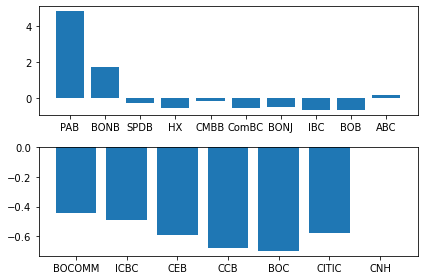

In [44]:
names =['PAB', 'BONB', 'SPDB', 'HX', 'CMBB', 'ComBC', 'BONJ', 'IBC', 'BOB', 'ABC']
names1 = ['BOCOMM', 'ICBC', 'CEB', 'CCB', 'BOC', 'CITIC', 'CNH']

fig,(ax1,ax2)=plt.subplots(2,1)
ax1.bar(names,Net[:10])
ax2.bar(names1,Net[10:])
plt.tight_layout()

For the China example, we see that for full-sample estimation the most important banks are PAB and BONB. Question: if we divided the sample in half will be get the same resutls?